Idea!
Icons zijn de retailers
Orderd by producten die ze verkopen (maybe productcategoriesn getallen toeweizen?)
Groepen gemaakt op Retailer categorie

Imports

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import pyodbc
import sqlite3
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import StandardScaler



Gather data

In [40]:
def getDbAsDF(conn: sqlite3.Connection, sql: str):
    cursor = conn.cursor()
    cursor.execute(sql)
    data = cursor.fetchall()

    columns = [column[0] for column in cursor.description]

    formatted_data = {}

    for i in range(len(columns)):
        dataList = []
        for j in data:
            dataList.append(j[i])
        formatted_data[columns[i]] = dataList

    df = pd.DataFrame(data=formatted_data, columns=columns)
    return df


# Connect to SQLite database
connection = sqlite3.connect(r'..\..\Data\merged.sqlite')

SQL = r"""
SELECT *
FROM order_header as OH
INNER JOIN retailer as R ON OH.RETAILER_NAME = R.COMPANY_NAME
INNER JOIN retailer_type as RT ON R.RETAILER_TYPE_CODE = RT.RETAILER_TYPE_CODE
INNER JOIN sales_demographic as SD ON R.RETAILER_CODEMR = SD.RETAILER_CODEMR
INNER JOIN order_details as OD ON OH.ORDER_NUMBER = OD.ORDER_NUMBER
INNER JOIN product as P ON P.PRODUCT_NUMBER = OD.PRODUCT_NUMBER
INNER JOIN product_type as PT ON PT.PRODUCT_TYPE_CODE = P.PRODUCT_TYPE_CODE
"""

DF = getDbAsDF(connection, SQL)
print(DF.columns)

DF[["UNIT_PRICE"]] = DF[["UNIT_PRICE"]].astype(float)
DF[["QUANTITY"]] = DF[["QUANTITY"]].astype(int)
DF[["PRODUCTION_COST"]] = DF[["PRODUCTION_COST"]].astype(float)
DF

Index(['ORDER_NUMBER', 'RETAILER_NAME', 'RETAILER_SITE_CODE',
       'RETAILER_CONTACT_CODE', 'SALES_STAFF_CODE', 'SALES_BRANCH_CODE',
       'ORDER_DATE', 'ORDER_METHOD_CODE', 'RETAILER_CODE', 'RETAILER_CODEMR',
       'COMPANY_NAME', 'RETAILER_TYPE_CODE', 'RETAILER_TYPE_CODE',
       'RETAILER_TYPE_EN', 'DEMOGRAPHIC_CODE', 'RETAILER_CODEMR',
       'AGE_GROUP_CODE', 'SALES_PERCENT', 'ORDER_DETAIL_CODE', 'ORDER_NUMBER',
       'PRODUCT_NUMBER', 'QUANTITY', 'UNIT_COST', 'UNIT_PRICE',
       'UNIT_SALE_PRICE', 'PRODUCT_NUMBER', 'INTRODUCTION_DATE',
       'PRODUCT_TYPE_CODE', 'PRODUCTION_COST', 'MARGIN', 'PRODUCT_IMAGE',
       'LANGUAGE', 'PRODUCT_NAME', 'DESCRIPTION', 'PRODUCT_TYPE_CODE',
       'PRODUCT_LINE_CODE', 'PRODUCT_TYPE_EN'],
      dtype='object')


,ORDER_NUMBER,RETAILER_NAME,RETAILER_SITE_CODE,RETAILER_CONTACT_CODE,SALES_STAFF_CODE,SALES_BRANCH_CODE,ORDER_DATE,ORDER_METHOD_CODE,RETAILER_CODE,RETAILER_CODEMR,...,PRODUCT_TYPE_CODE,PRODUCTION_COST,MARGIN,PRODUCT_IMAGE,LANGUAGE,PRODUCT_NAME,DESCRIPTION,PRODUCT_TYPE_CODE,PRODUCT_LINE_CODE,PRODUCT_TYPE_EN
0,1831,Sport & Freizeit,36,52,15,13,2022-11-11 00:00:00,4,48,24,...,10,30.00,.33,P63PA3WT10.jpg,EN,Mountain Man Analog,"Padded leather strap, precision Swiss quartz m...",10,3,Watches
1,1831,Sport & Freizeit,36,52,15,13,2022-11-11 00:00:00,4,48,24,...,11,46.15,.23,P68PA3EW11.jpg,EN,Polar Sun,The Polar Sun sunglasses have 3 mm thick lense...,11,3,Eyewear
2,1831,Sport & Freizeit,36,52,15,13,2022-11-11 00:00:00,4,48,24,...,11,60.00,.33,P71PA3EW11.jpg,EN,Polar Wave,Acrylex lenses in the Polar Wave sunglasses ab...,11,3,Eyewear
3,1831,Sport & Freizeit,36,52,15,13,2022-11-11 00:00:00,4,48,24,...,13,79.19,.2,P78PA3BN13.jpg,EN,Seeker 35,This 7 x 35 model is economical and performs w...,13,3,Binoculars
4,1831,Sport & Freizeit,36,52,15,13,2022-11-11 00:00:00,4,48,24,...,10,30.00,.33,P63PA3WT10.jpg,EN,Mountain Man Analog,"Padded leather strap, precision Swiss quartz m...",10,3,Watches
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182993,9242,"Chen Yu Enterprise Co.,",363,354,104,33,2022-10-07 00:00:00,2,172,575,...,13,79.19,.2,P78PA3BN13.jpg,EN,Seeker 35,This 7 x 35 model is economical and performs w...,13,3,Binoculars
182994,9242,"Chen Yu Enterprise Co.,",363,354,104,33,2022-10-07 00:00:00,2,172,575,...,14,20.00,.33,P82PA3NV14.jpg,EN,Glacier Basic,Traditional magnetic compass in a stainless st...,14,3,Navigation
182995,9242,"Chen Yu Enterprise Co.,",363,354,104,33,2022-10-07 00:00:00,2,172,575,...,16,2.00,.6,P91OP4SS16.jpg,EN,Sun Shelter 30,SPF 30 provides maximum protection and is long...,16,4,Sunscreen
182996,9242,"Chen Yu Enterprise Co.,",363,354,104,33,2022-10-07 00:00:00,2,172,575,...,17,16.43,.28,P96OP4FA17.jpg,EN,Compact Relief Kit,A personal first aid kit is recommended for ev...,17,4,First Aid


Selecting Data

In [41]:
DF.T.drop_duplicates().T
Retailers = DF["RETAILER_CODE"].unique()
dataset = pd.DataFrame(columns=["Quantity","Totaalprijs","Retailer"])
for number in Retailers:
    quantity = 0
    price = 0
    list1 = []
    list2 = []
    list3 = []
    FoundRows = DF.loc[DF['RETAILER_CODE'] == number]
    #Yes this works, no I cannot wrap my head arround dataframes.
    for row in FoundRows["QUANTITY"]:
        quantity += row
        list1.append(row)
    for row in FoundRows["UNIT_PRICE"]:
        list2.append(row)
    for row in FoundRows["PRODUCTION_COST"]:
        list3.append(row)
    for i in range(len(list1)):
        price+=list1[i]*(list2[i]-list3[i])

    dataset.loc[len(dataset)] = {"Retailer":number,"Quantity":quantity,"Totaalprijs":price}

print(dataset.sort_values(by=['Totaalprijs'], ascending=False))


# Data = DF[["RETAILER_CODE","UNIT_PRICE","QUANTITY","AGE_GROUP_CODE"]]

# Data = Data.T.drop_duplicates().T
# Data.dropna(inplace = True)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(dataset)
scaled_features

    Quantity  Totaalprijs Retailer
16   1058022  34921781.46       95
6     567968  16871192.48       54
47    583692  15569622.48      160
35    320340  11813875.80      104
56    432912  11460166.56      145
..       ...          ...      ...
3      10336    427019.84       57
51      4020    183118.56      131
4       6608    174308.54       58
25      3828    122905.32      111
27      3088     90338.88      105

[72 rows x 3 columns]


array([[ 3.66789295e-01, -1.04298346e-02, -1.68868866e+00],
       [ 7.12675905e-01,  5.33011704e-01, -1.64373189e+00],
       [-1.43603348e-01, -2.87648811e-01, -1.71116704e+00],
       [-7.46990053e-01, -7.68129743e-01, -1.48638320e+00],
       [-7.69125276e-01, -8.18432622e-01, -1.46390481e+00],
       [-6.56810394e-01,  1.03551118e-01, -1.66621028e+00],
       [ 2.56398331e+00,  2.50512803e+00, -1.55381835e+00],
       [-7.16922250e-01, -3.04535220e-01, -2.43047536e+00],
       [-2.95190735e-02, -2.61851185e-01, -2.04834282e+00],
       [ 1.12260504e+00,  6.68816816e-01, -1.98090766e+00],
       [-7.09869913e-02,  2.12080617e-01,  4.21469715e-02],
       [-2.77329071e-01, -3.86897412e-01, -2.25064828e+00],
       [-7.36326196e-01, -6.82324281e-01,  8.71037412e-02],
       [-1.72639500e-02, -2.85147045e-01,  1.09582126e-01],
       [ 1.18861883e+00,  1.41047232e+00, -6.99639728e-01],
       [-7.70538415e-01, -6.71903265e-01, -6.77161343e-01],
       [ 5.47370825e+00,  6.09814740e+00

Clustering

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


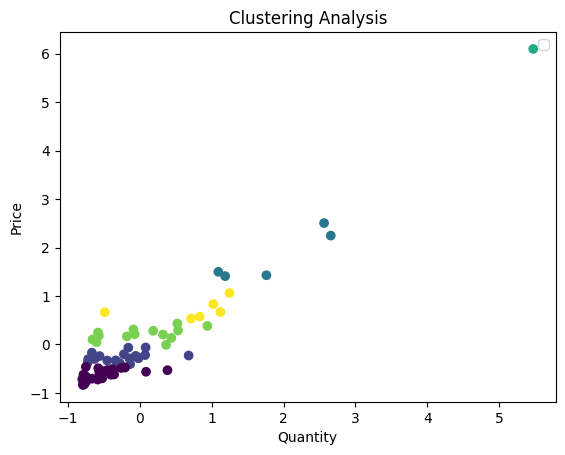

In [42]:

kmeans = KMeans(n_clusters=6, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0)

y_km = kmeans.fit(dataset)
cluster_labels = kmeans.labels_

plt.scatter(scaled_features[:,0], scaled_features[:,1], c=cluster_labels)
plt.xlabel('Quantity')
plt.ylabel('Price')
plt.title('Clustering Analysis')
plt.grid
plt.legend()
plt.show()

Calculate distortion

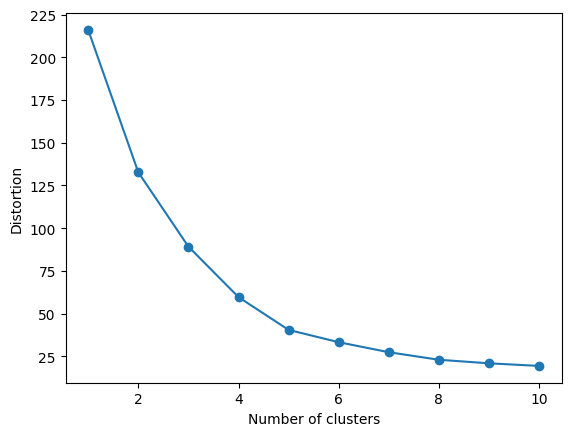

In [43]:
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(scaled_features)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

Check against type

In [45]:
# Create the 'Category' column based on 'Quantity' and 'Totaalprijs'
dataset['Retailer-Name'] = dataset['Retailer'].apply(lambda retailer: DF.loc[DF['RETAILER_CODE'] == retailer, 'RETAILER_NAME'].iloc[0])
# dataset['Category'] = dataset['Retailer'].apply(lambda retailer: DF.loc[DF['RETAILER_CODE'] == retailer, 'RETAILER_TYPE_CODE'].iloc[0])
dataset['Category-Name'] = dataset['Retailer'].apply(lambda retailer: DF.loc[DF['RETAILER_CODE'] == retailer, 'RETAILER_TYPE_EN'].iloc[0])

print(dataset)

    Quantity  Totaalprijs Retailer                     Retailer-Name  \
0     197918   4233548.06       48                  Sport & Freizeit   
1     256172   6963686.38       50                     Die Zeltstadt   
2     111958   2840857.04       47                Der Fitness-Doktor   
3      10336    427019.84       57                       Rad und Tat   
4       6608    174308.54       58                         Weitblick   
..       ...          ...      ...                               ...   
67    308390   8468627.10      181             Jensen Mountaineering   
68    250716   3138691.56      182                      Leisure Land   
69     38292   5518245.12      180                 Hurst Ironmongers   
70      7100    989092.10      186                    Arnold's Clubs   
71     40368   5192197.08      174  Hai Wan Shin Sport Equipment Co.   

       Category-Name  
0   Department Store  
1    Warehouse Store  
2       Sports Store  
3   Direct Marketing  
4      Eyewear Store